In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
import meshio
import os
import time
from scipy.interpolate import griddata
from sklearn.model_selection import train_test_split
from tensorflow import keras

import tensorflow as tf


# Loading Dataset

In [2]:
x = np.arange(0.006, 0.0135, (0.0135-0.006)/300)
y = np.arange(0, 0.0025, 0.0025/75)

data_path = './Data'
path_sep = '\\' # use '/' for Unix and '\\' for Windows
folders = os.listdir(data_path)
        
subfolder = []
path = []
names = []
condition = []

for i in folders:
    if os.path.isdir(data_path + path_sep + i): 
        subfolder.append(data_path + path_sep + i)

for folder in subfolder:
    files = os.listdir(folder + path_sep)
    for i in files:
        ext = os.path.splitext(i)
        if (ext[-1].lower() == '.vtk') & (ext[0][-2] != '_'):
            names.append(ext[0])
            string = ext[0].replace('ER', '').replace('Tin', '').replace('Uin', '').replace('Twall', '').split('_')[0:4]
            var = []
            for j in string:
                if j == 'Adiabatic':
                    var.append(0.)
                else:
                    var.append(float(j))
            condition.append(var)

Q_list = []
for folder in subfolder:
    files = os.listdir(folder + path_sep)
    for counter,file in enumerate(files):
        mesh = meshio.read(folder+ path_sep +file)
        points = mesh.points
        Qdot = mesh.point_data['Qdot']
        boolArr = (points[:,1] == 0) & (points[:,0] >= 0.006)  
        Qdot = Qdot[boolArr]
        points = points[boolArr]
        old_points = points[:,[0, 2]]
        grid_x, grid_y = np.meshgrid(x, y)
        grid_new = griddata(old_points, Qdot, (grid_x, grid_y), method='nearest')
        Q_list.append(grid_new)
Q_list

[array([[ 3.61856003e-03,  4.39265510e-03,  5.28152985e-03, ...,
          2.38248008e+04,  2.38248008e+04,  1.11345332e+04],
        [ 4.40118741e-03,  5.34549495e-03,  6.42971741e-03, ...,
          2.38063750e+04,  2.38063750e+04,  0.00000000e+00],
        [ 7.07099773e-03,  8.59951973e-03,  1.03551522e-02, ...,
          2.37511758e+04,  2.37511758e+04,  0.00000000e+00],
        ...,
        [ 0.00000000e+00,  2.66685000e+04,  2.65656758e+04, ...,
         -2.31023242e+04, -2.31023242e+04,  0.00000000e+00],
        [ 0.00000000e+00,  2.17416992e+04,  2.16524258e+04, ...,
         -2.31955000e+04, -2.31955000e+04,  0.00000000e+00],
        [ 0.00000000e+00,  1.89000000e+04,  1.88187500e+04, ...,
         -2.32515000e+04, -2.32515000e+04,  0.00000000e+00]]),
 array([[ 5.41827525e-04,  6.63888000e-04,  8.06319527e-04, ...,
          4.47813516e+04,  4.47813516e+04,  2.09737695e+04],
        [ 6.82140002e-04,  8.36730003e-04,  1.01713976e-03, ...,
          4.47488008e+04,  4.47488008e

# Data Preparation

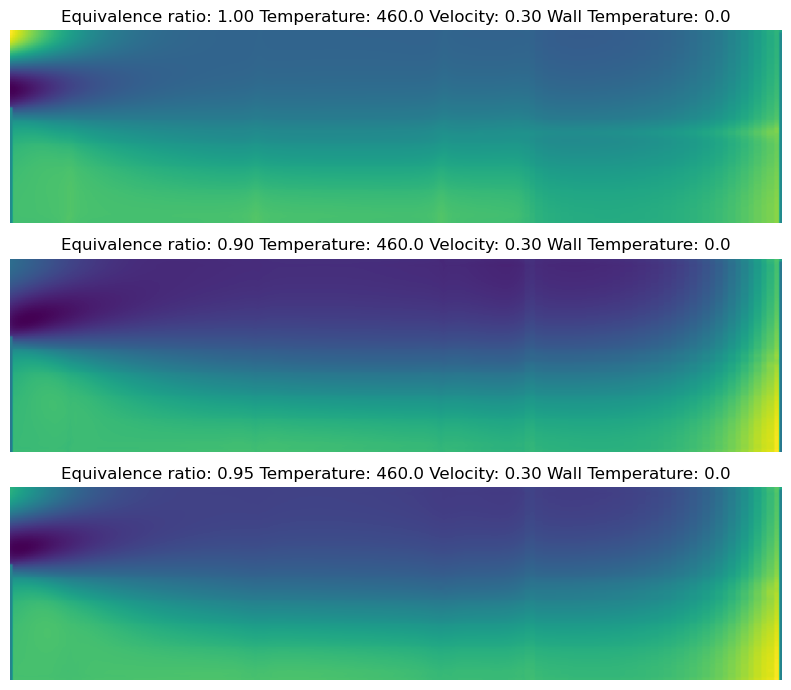

In [3]:
Qdot = np.array(Q_list)
indices = [10, 88, 100]
# OutLier
fig, axs = plt.subplots(len(indices),1,figsize=(15, 7))
# Equivalence ratio (1.0)
# Temperature (460)
# Velocity (0.50 m/s)
# Wall Temperature (373 or None)
for idx, i in enumerate(indices):
    img = Qdot[i]
    axs[idx].imshow(img)
    axs[idx].set_title(f'Equivalence ratio: {condition[i][0] * 0.001:.2f} '
                       f'Temperature: {condition[i][1]} '
                       f'Velocity: {condition[i][2] * 0.01:.2f} '
                       f'Wall Temperature: {condition[i][3]}')
    axs[idx].axis('off')  
plt.tight_layout()
plt.show()

In [12]:
Qdot = np.delete(Qdot, indices, axis=0)
condition = np.delete(condition, indices, axis=0)

# Data Normalization
Qdot = Qdot / np.max(Qdot)
mean = Qdot.mean(axis = 0)
Qdot = np.reshape(Qdot, (-1, 75, 300, 1))

# Label Normalization
normaliser = []
conditions = np.array(condition)
df = np.zeros(conditions.shape)
for i in range(conditions.shape[1]):
    df[:,i] = conditions[:,i] / np.max(conditions[:,i])
    normaliser.append(np.max(conditions[:,i]))

# Data split
train_data, test_data, label_train, label_test = train_test_split(Qdot, df, test_size = 0.15, shuffle=True)

In [5]:
# Data augmentation

datagen = keras.preprocessing.image.ImageDataGenerator(
    width_shift_range=0.05, 
    height_shift_range=0.05,     
    zoom_range=0.1,   
    fill_mode='nearest'  
)

train_data_augmented = []
label_train_augmented = []
for i in range(train_data.shape[0]):
    img = train_data[i].reshape((1, 75, 300, 1)) 
    it = datagen.flow(img, batch_size=1)
    
    for _ in range(5):
        batch = it.next()
        train_data_augmented.append(batch[0])
        label_train_augmented.append(label_train[i])     
        
train_data_augmented = np.array(train_data_augmented)
label_train_augmented = np.array(label_train_augmented)

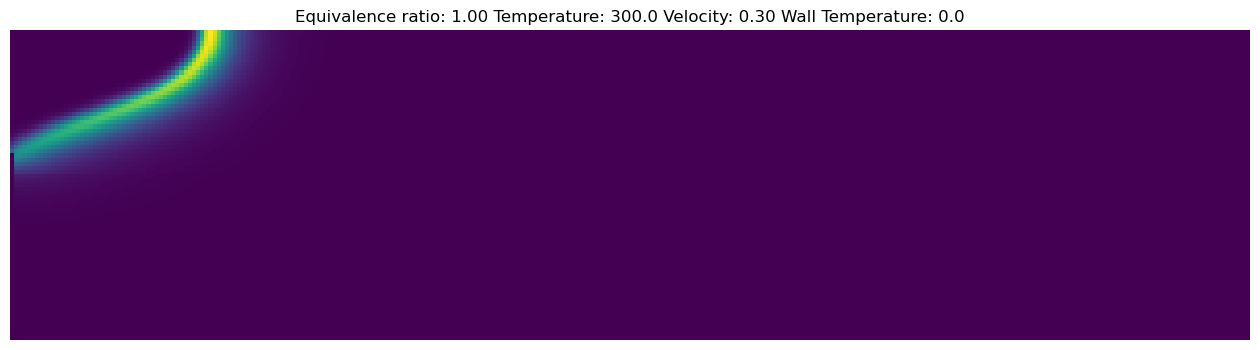

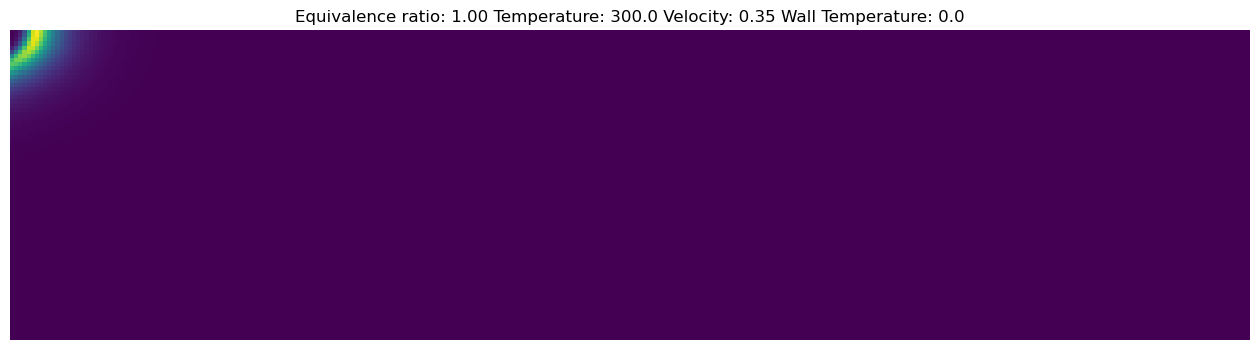

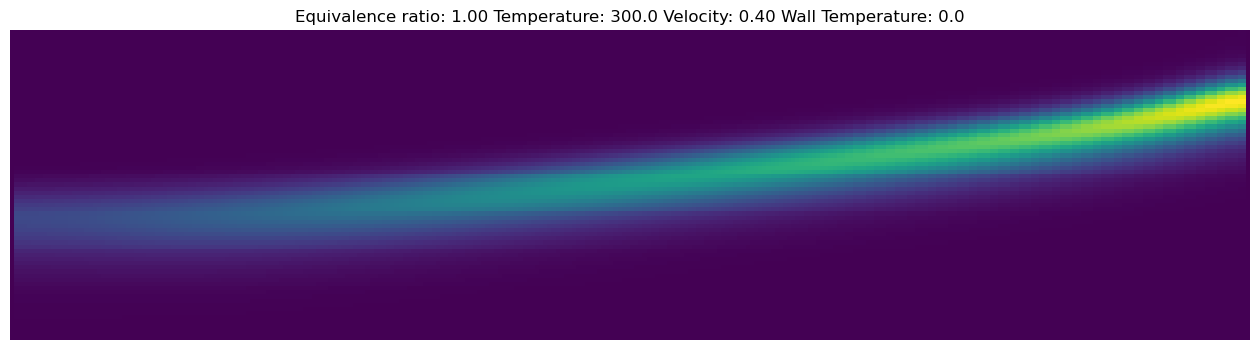

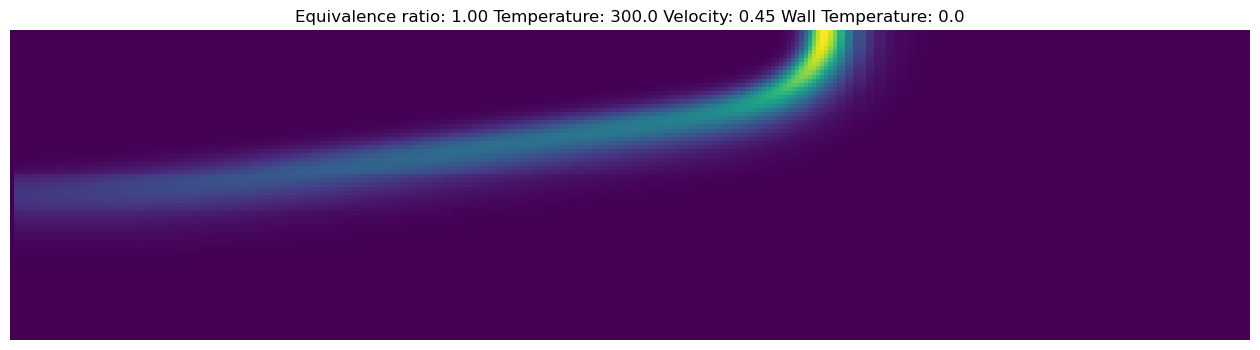

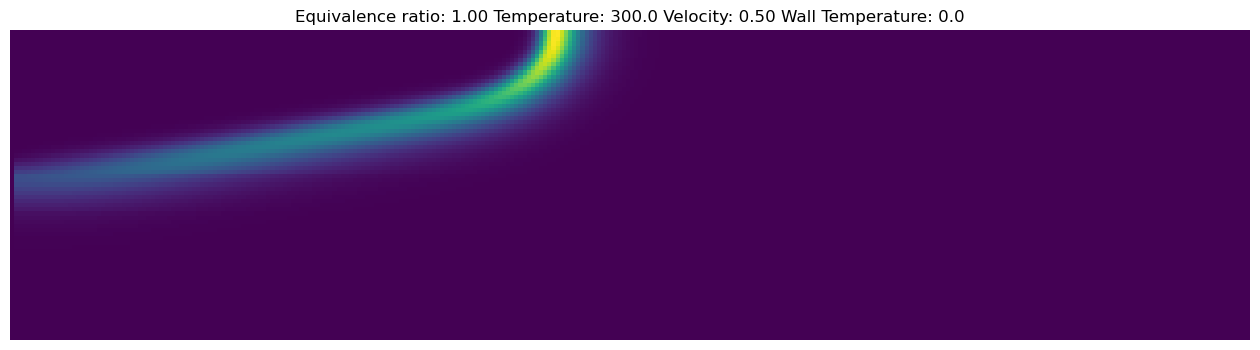

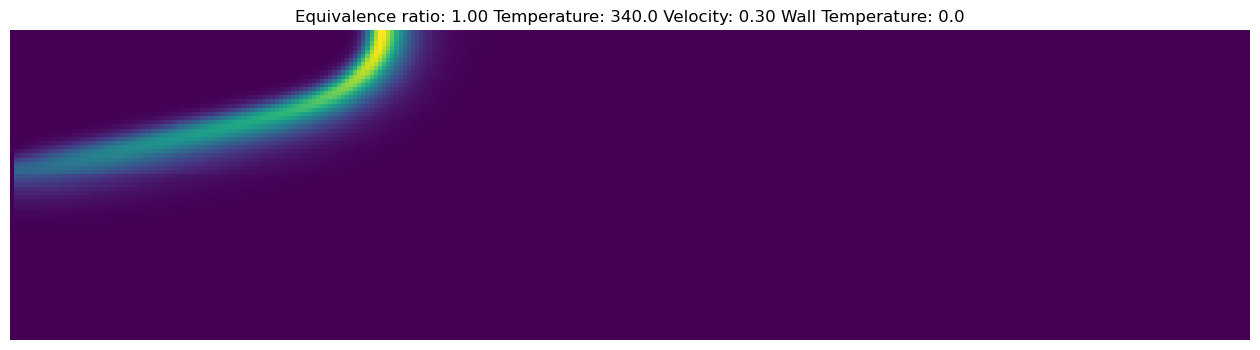

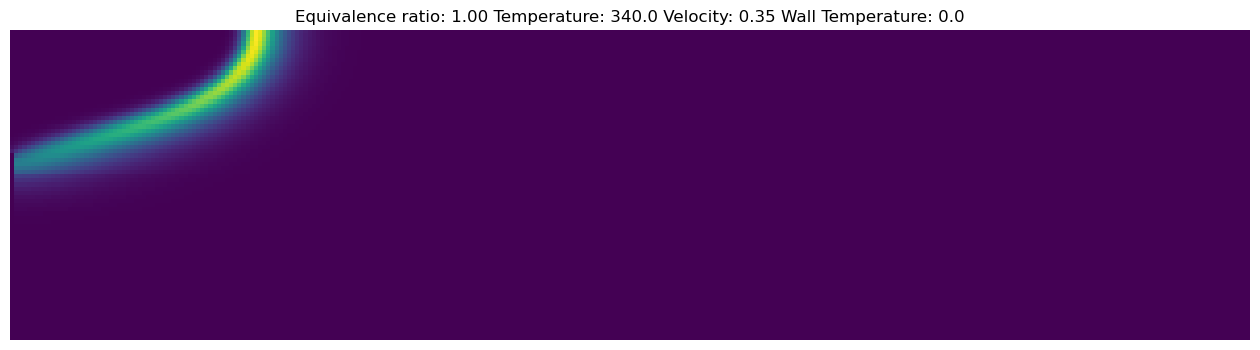

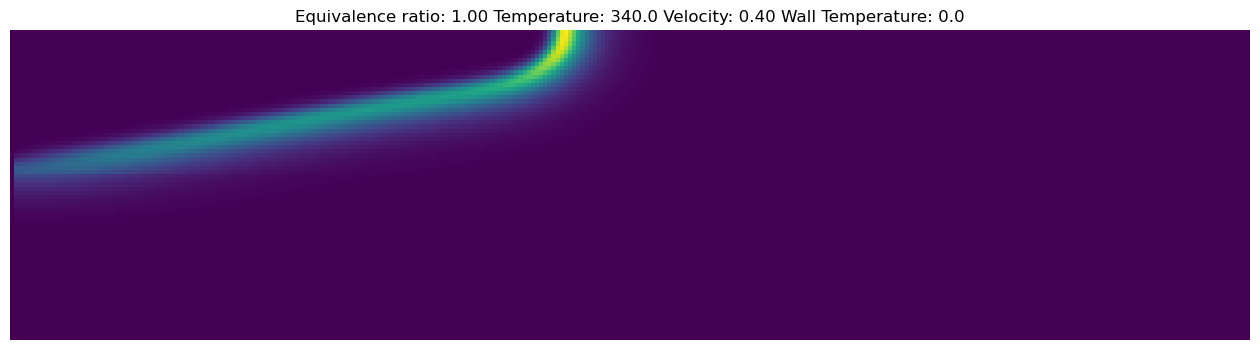

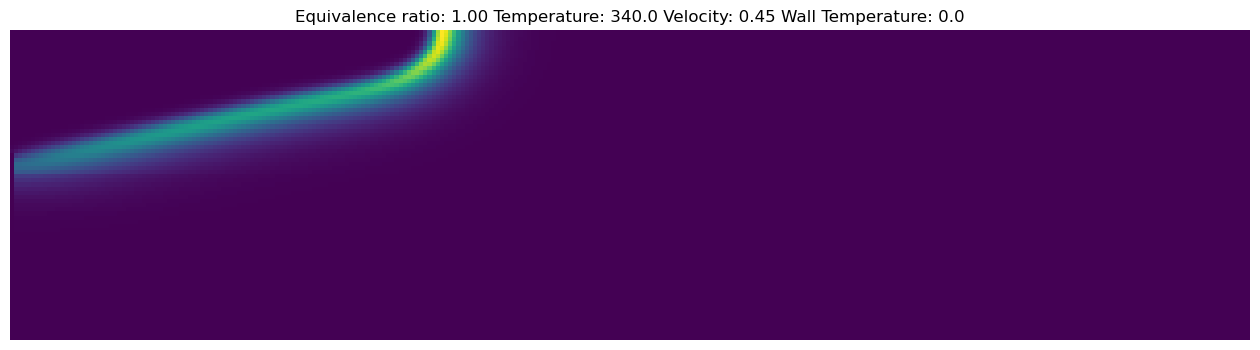

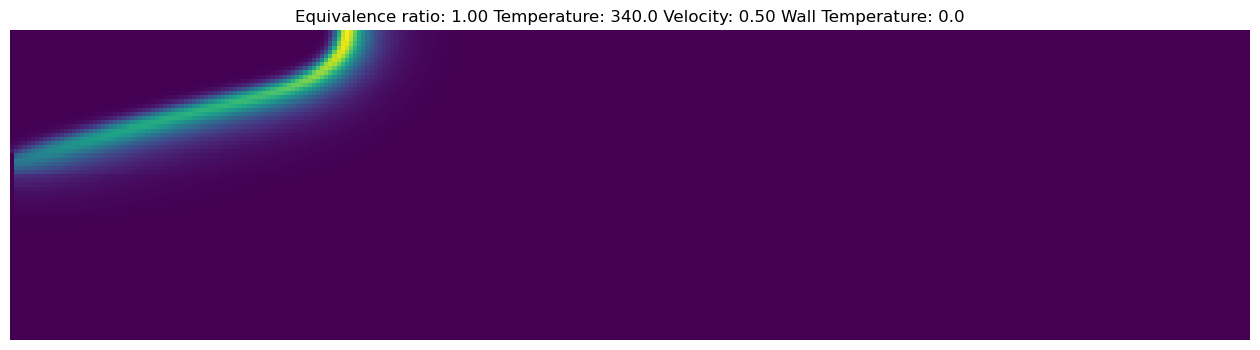

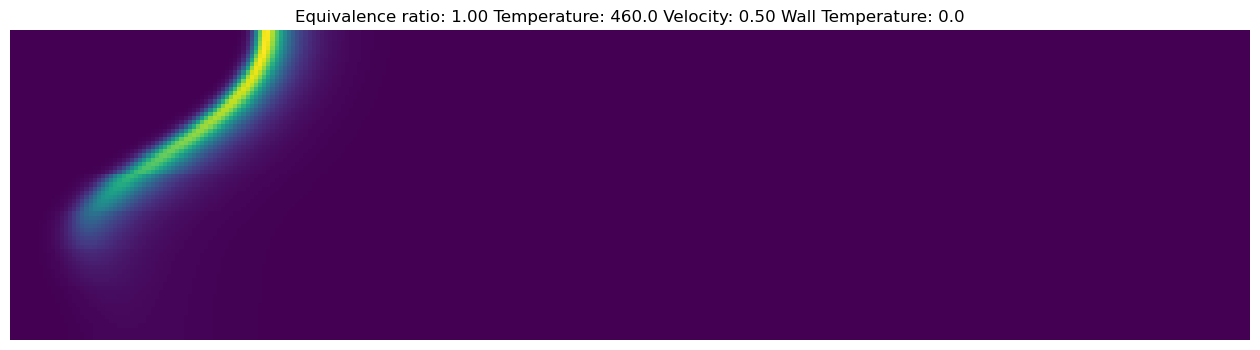

In [6]:

for i in range(236//20):
    fig = plt.figure(figsize=(16, 80))
    plt.imshow(np.reshape(Qdot[i*10],(75, 300)))
    plt.axis('off')
    #print the input data
    #print out the condition data for that image as well
    # print(condition[i*10])

    #print out the parameters for the image
    #temperature, velocity, wall temperature
    #equivalence ratio
    plt.title(f'Equivalence ratio: {condition[i][0] * 0.001:.2f} '
                       f'Temperature: {condition[i][1]} '
                       f'Velocity: {condition[i][2] * 0.01:.2f} '
                       f'Wall Temperature: {condition[i][3]}')


IndexError: index 236 is out of bounds for axis 0 with size 236

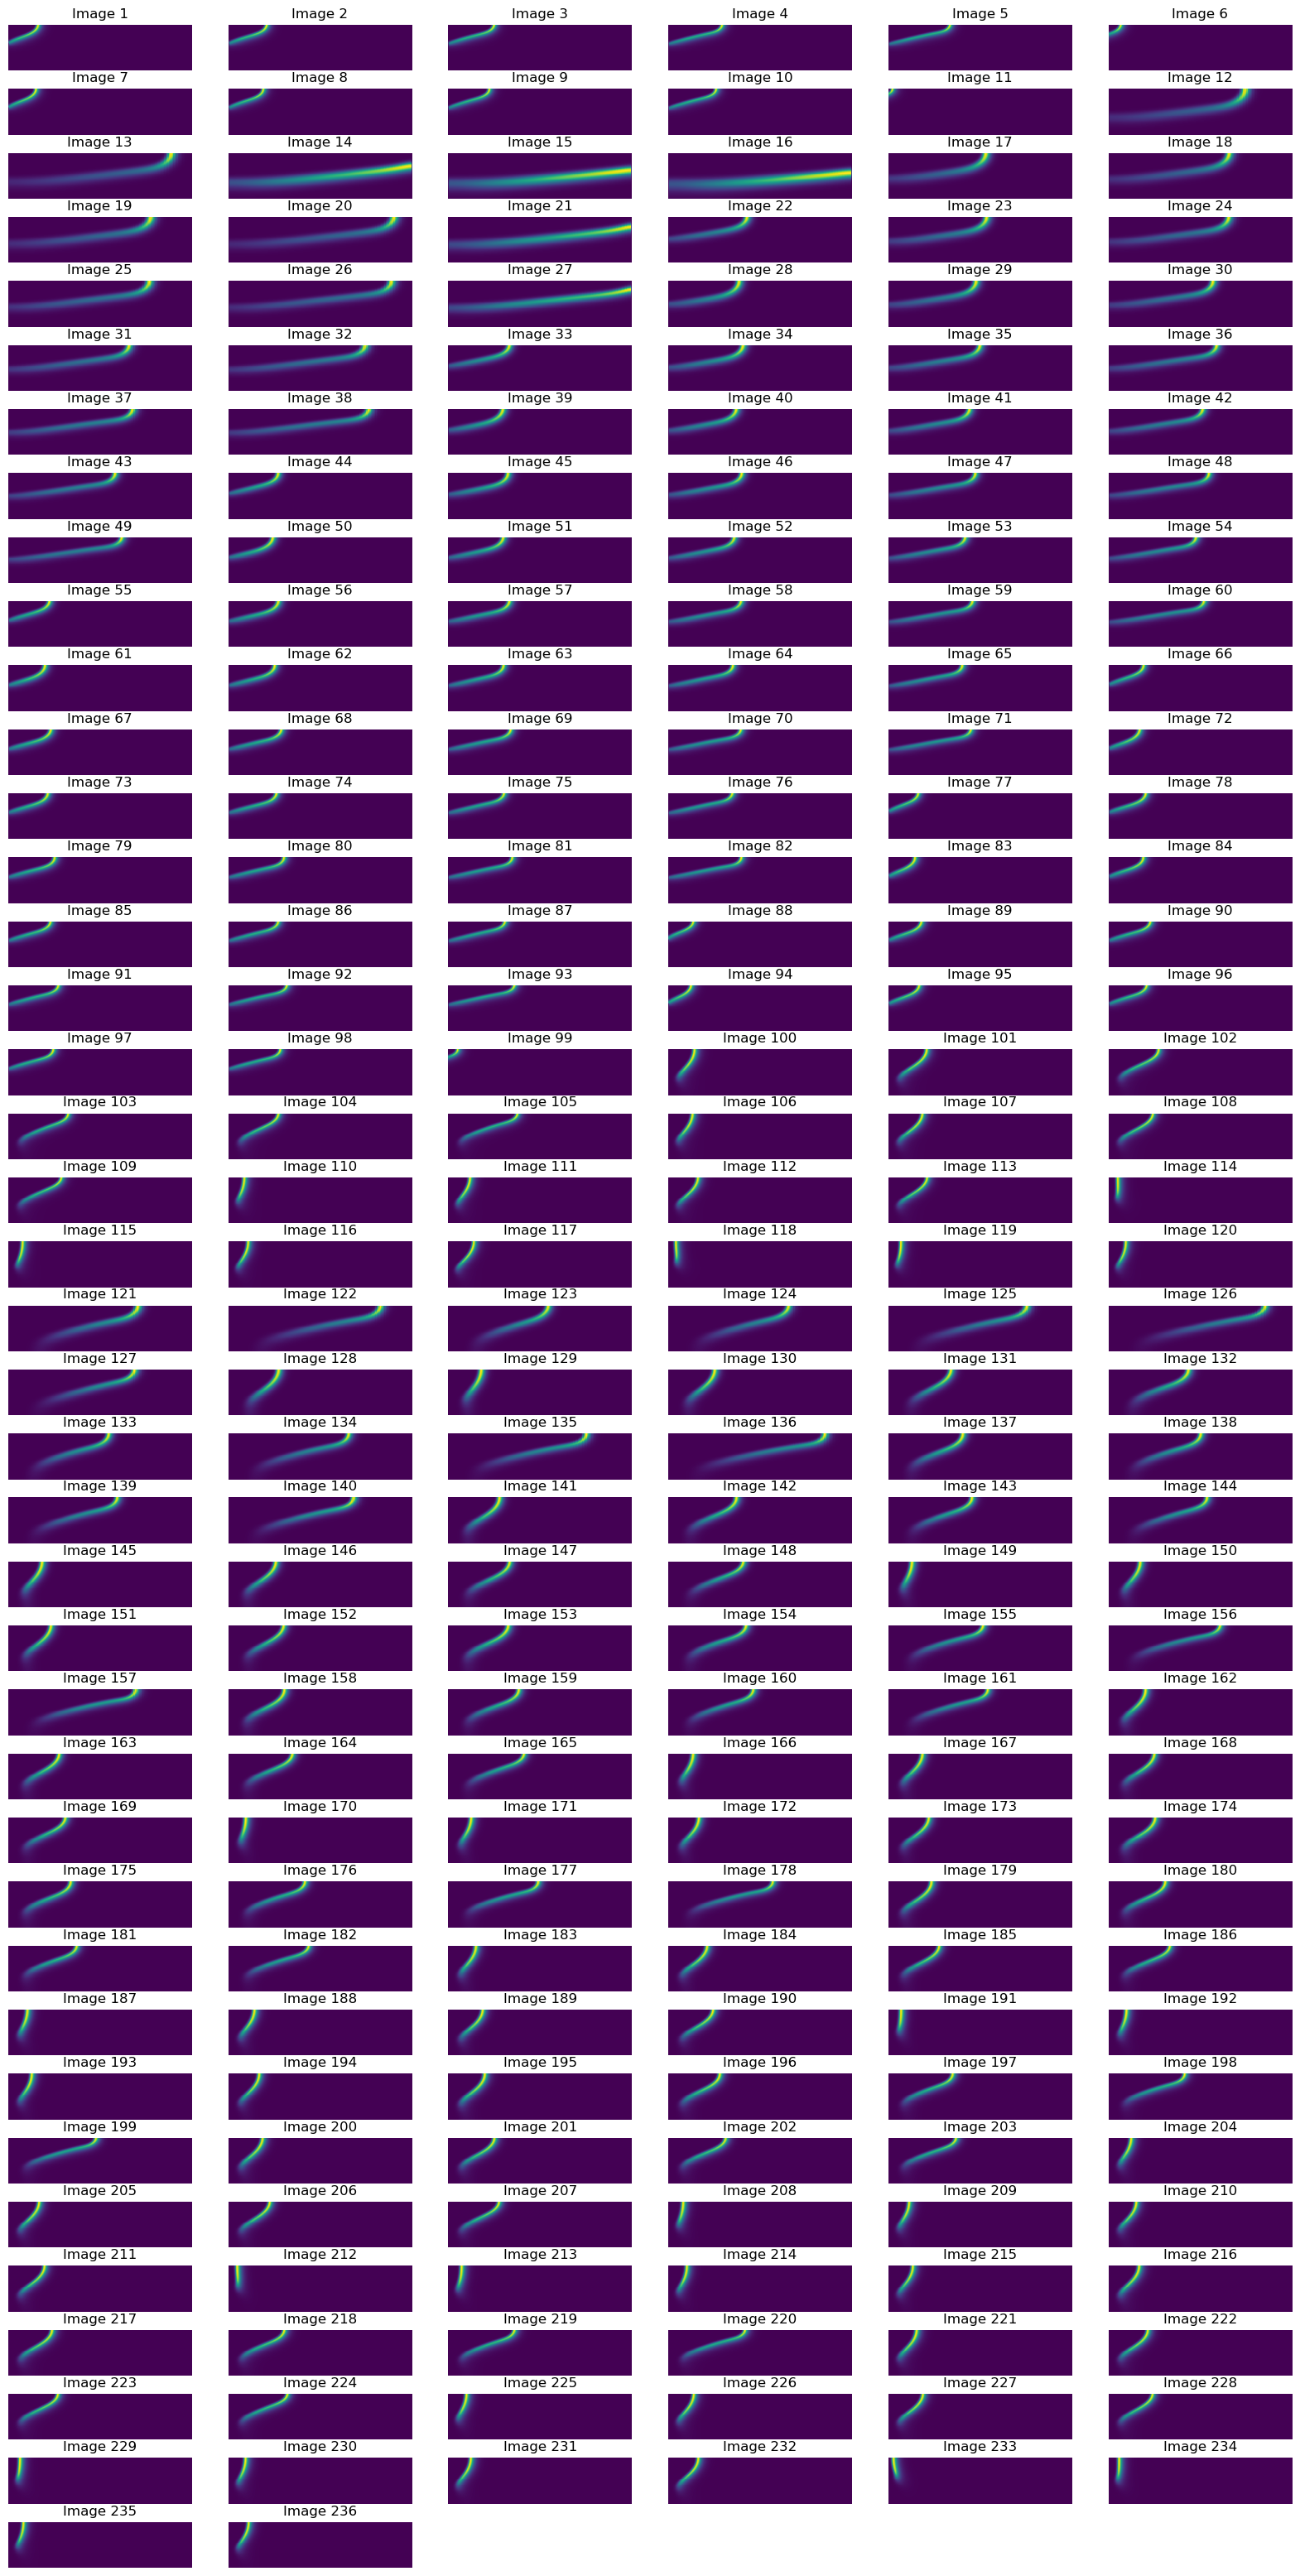

In [7]:
fig = plt.figure(figsize=(20, 40))
columns = 6
rows = 40

for i in range(1, columns * rows):
    img = Qdot[(i-1)]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.title(f"Image {i}")  
    plt.axis('off')
plt.show()

# Outlier imgs: 11 89 101

# Model define 


## Convolutional Autoencoder

In [8]:
class Autoencoder(tf.keras.Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    
    self.encoder = tf.keras.Sequential([
      # Input layer 
      tf.keras.layers.InputLayer(input_shape = (75,300,1)),
      
      # Conv layer + BatchNom + LeakyReLU + MaxPooling
      tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=1, padding='same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.LeakyReLU(0.2),
      tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
      # tf.keras.layers.Dropout(0.3),       
      
      # Conv layer + BatchNom + LeakyReLU + MaxPooling
      tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides=1,padding='same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.LeakyReLU(0.2),
      tf.keras.layers.MaxPooling2D(pool_size=(5, 5)),
      # tf.keras.layers.Dropout(0.3),         
      
      # Conv layer + BatchNom + LeakyReLU + MaxPooling
      tf.keras.layers.Conv2D(filters=64, kernel_size=5, strides=1,padding='same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.LeakyReLU(0.2),
      tf.keras.layers.MaxPooling2D(pool_size=(5, 5)),
      # tf.keras.layers.Dropout(0.3),   
          
      # Flatten  
      tf.keras.layers.Flatten(),
      
      # Fully NN --> Laten variables
      tf.keras.layers.Dense(latent_dim)
    ])
    
    self.decoder = tf.keras.Sequential([
      tf.keras.layers.InputLayer(input_shape = (latent_dim,)),
      
      # Fully NN 
      tf.keras.layers.Dense(units = 1*4*64),
      tf.keras.layers.Reshape(target_shape = (1,4,64)),
      
      # Conv layer 
      tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=5, strides=5,padding='same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.LeakyReLU(0.2),     
      
       # Conv layer 
      tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=5, strides=1,padding='same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.LeakyReLU(0.2),     

      # Conv layer  
      tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=5, strides=5,padding='same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.LeakyReLU(0.2),
      
      # Conv layer  
      tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=5, strides=1,padding='same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.LeakyReLU(0.2),
                            
      # Conv layer 
      tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=3, strides=3, padding='same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.LeakyReLU(0.2),
      
      # Conv layer 
      tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=3, strides=1, padding='same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.LeakyReLU(0.2),
      
      tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1,padding='same', activation='sigmoid'),
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


latent_dim = 8
CAE = Autoencoder(latent_dim)
CAE.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4), loss='mse')

# CAE.encoder.summary()
# CAE.decoder.summary()

## Variantional autoencoder

- Encoder: change output to mean and log variance
- Decoder: add loss function Kullback–Leibler divergence term

In [10]:
class variational_autoencoder(tf.keras.Model):
  def __init__(self, latent_dim):
    super(variational_autoencoder, self).__init__()
    self.latent_dim = latent_dim
    
    self.encoder = tf.keras.Sequential([
      # Input layer 
      tf.keras.layers.InputLayer(input_shape = (75,300,1)),
      
      # Conv layer + BatchNom + LeakyReLU + MaxPooling
      tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=1, padding='same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.LeakyReLU(0.2),
      tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
      # tf.keras.layers.Dropout(0.3),       
      
      # Conv layer + BatchNom + LeakyReLU + MaxPooling
      tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides=1,padding='same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.LeakyReLU(0.2),
      tf.keras.layers.MaxPooling2D(pool_size=(5, 5)),
      # tf.keras.layers.Dropout(0.3),         
      
      # Conv layer + BatchNom + LeakyReLU + MaxPooling
      tf.keras.layers.Conv2D(filters=64, kernel_size=5, strides=1,padding='same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.LeakyReLU(0.2),
      tf.keras.layers.MaxPooling2D(pool_size=(5, 5)),
      # tf.keras.layers.Dropout(0.3),   
          
      # Flatten  
      tf.keras.layers.Flatten(),
      
      # Fully NN --> Laten variables
      tf.keras.layers.Dense(latent_dim*2)
    ])
    
    self.decoder = tf.keras.Sequential([
      tf.keras.layers.InputLayer(input_shape = (latent_dim,)),
      
      # Fully NN 
      tf.keras.layers.Dense(units = 1*4*64),
      tf.keras.layers.Reshape(target_shape = (1,4,64)),
      
      # Conv layer 
      tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=5, strides=5,padding='same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.LeakyReLU(0.2),     
      
       # Conv layer 
      tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=5, strides=1,padding='same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.LeakyReLU(0.2),     

      # Conv layer  
      tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=5, strides=5,padding='same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.LeakyReLU(0.2),
      
      # Conv layer  
      tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=5, strides=1,padding='same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.LeakyReLU(0.2),
                            
      # Conv layer 
      tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=3, strides=3, padding='same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.LeakyReLU(0.2),
      
      # Conv layer 
      tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=3, strides=1, padding='same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.LeakyReLU(0.2),
      
      tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1,padding='same', activation='sigmoid'),
    ])

  def sample(self, mean, log_var):
      """Reparameterization trick by sampling from an isotropic unit Gaussian."""
      epsilon = tf.random.normal(shape=tf.shape(mean))
      return mean + tf.exp(0.5 * log_var) * epsilon

  def call(self, x):
      """Forward pass through VAE."""
      # Encode to get mean and log variance
      z_mean_log_var = self.encoder(x)
      z_mean, z_log_var = tf.split(z_mean_log_var, num_or_size_splits=2, axis=1)
      
      # Reparameterization trick to sample latent space
      z = self.sample(z_mean, z_log_var)
      
      # Decode to reconstruct
      reconstructed = self.decoder(z)
      
      # KL divergence loss
      beta = 0.1
      kl_loss = beta * (-0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))
      # tf.print("KL Loss:", tf.reduce_mean(kl_loss)) 
    
      # Add KL divergence loss to the total loss
      self.add_loss(tf.reduce_mean(kl_loss))  
      
      return reconstructed
    
latent_dim = 8
VAE = variational_autoencoder(latent_dim)
VAE.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='binary_crossentropy')

# VAE.encoder.summary()
# VAE.decoder.summary()

# Model training

In [9]:
# # CAE Model Training
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# hist_cae = CAE.fit(train_data, train_data,epochs=200,batch_size = 8,validation_data=(test_data, test_data), callbacks=[early_stopping])

hist_cae = CAE.fit(train_data_augmented, train_data_augmented,epochs=200,batch_size = 8,validation_data=(test_data, test_data))

Epoch 1/200
125/125 [==============================] - 11s 74ms/step - loss: 0.1170 - val_loss: 0.1613
Epoch 2/200
125/125 [==============================] - 12s 93ms/step - loss: 0.0415 - val_loss: 0.0771
Epoch 3/200
125/125 [==============================] - 10s 81ms/step - loss: 0.0232 - val_loss: 0.0314
Epoch 4/200
125/125 [==============================] - 10s 78ms/step - loss: 0.0150 - val_loss: 0.0164
Epoch 5/200
125/125 [==============================] - 10s 79ms/step - loss: 0.0107 - val_loss: 0.0104
Epoch 6/200
125/125 [==============================] - 15s 122ms/step - loss: 0.0080 - val_loss: 0.0075
Epoch 7/200
125/125 [==============================] - 15s 122ms/step - loss: 0.0064 - val_loss: 0.0061
Epoch 8/200
125/125 [==============================] - 12s 96ms/step - loss: 0.0052 - val_loss: 0.0048
Epoch 9/200
125/125 [==============================] - 10s 78ms/step - loss: 0.0043 - val_loss: 0.0038
Epoch 10/200
125/125 [==============================] - 11s 88ms/step -

In [12]:
hist_vae = VAE.fit(train_data, train_data, epochs=200, batch_size=8, validation_data=(test_data, test_data))


Epoch 1/200


25/25 [==============================] - 5s 115ms/step - loss: 9.5266 - val_loss: 0.6987
Epoch 2/200
25/25 [==============================] - 2s 89ms/step - loss: 2.2194 - val_loss: 0.6973
Epoch 3/200
25/25 [==============================] - 2s 88ms/step - loss: 1.3593 - val_loss: 0.6851
Epoch 4/200
25/25 [==============================] - 2s 92ms/step - loss: 1.0267 - val_loss: 0.6663
Epoch 5/200
25/25 [==============================] - 2s 96ms/step - loss: 0.8577 - val_loss: 0.6443
Epoch 6/200
25/25 [==============================] - 2s 89ms/step - loss: 0.7462 - val_loss: 0.6241
Epoch 7/200
25/25 [==============================] - 3s 130ms/step - loss: 0.6478 - val_loss: 0.5980
Epoch 8/200
25/25 [==============================] - 3s 110ms/step - loss: 0.5781 - val_loss: 0.5666
Epoch 9/200
25/25 [==============================] - 2s 91ms/step - loss: 0.5231 - val_loss: 0.5326
Epoch 10/200
25/25 [==============================] - 2s 95ms/step - loss: 0.4766 - val_loss: 0.4893
Epoch 11

## Results

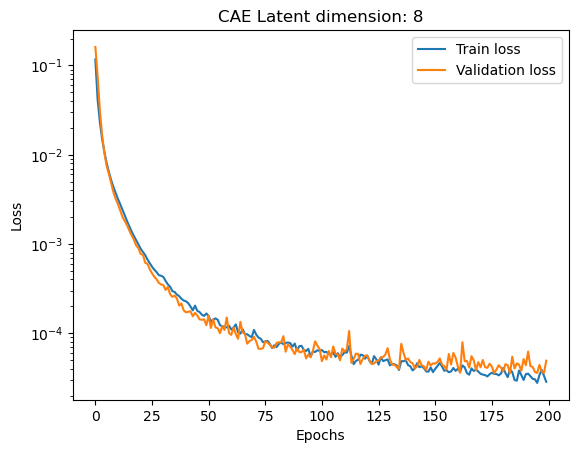

In [10]:
# Results CAE
loss = hist_cae.history['loss']
val_loss = hist_cae.history['val_loss']

plt.semilogy(loss, label ='Train loss')
plt.semilogy(val_loss, label = 'Validation loss')
# plt.plot(loss, label ='Train loss')
# plt.plot(val_loss, label = 'Validation loss')
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.title(f'CAE Latent dimension: {latent_dim}')
plt.legend()
plt.show()

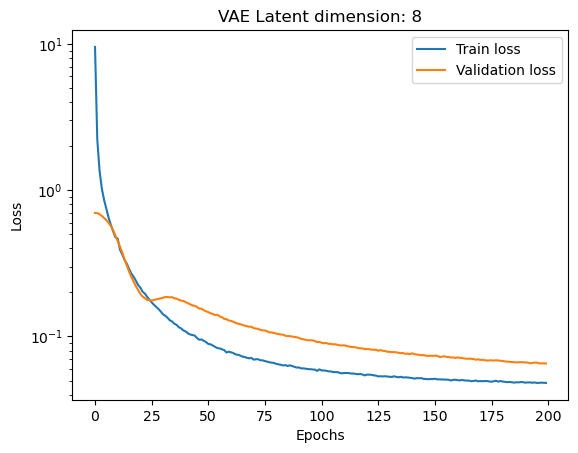

In [14]:
# Results VAE
loss = hist_vae.history['loss']
val_loss = hist_vae.history['val_loss']

plt.semilogy(loss, label ='Train loss')
plt.semilogy(val_loss, label = 'Validation loss')
# plt.plot(loss, label ='Train loss')
# plt.plot(val_loss, label = 'Validation loss')
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.title(f'VAE Latent dimension: {latent_dim}')
plt.legend()
plt.show()

## Visualization

### CAE

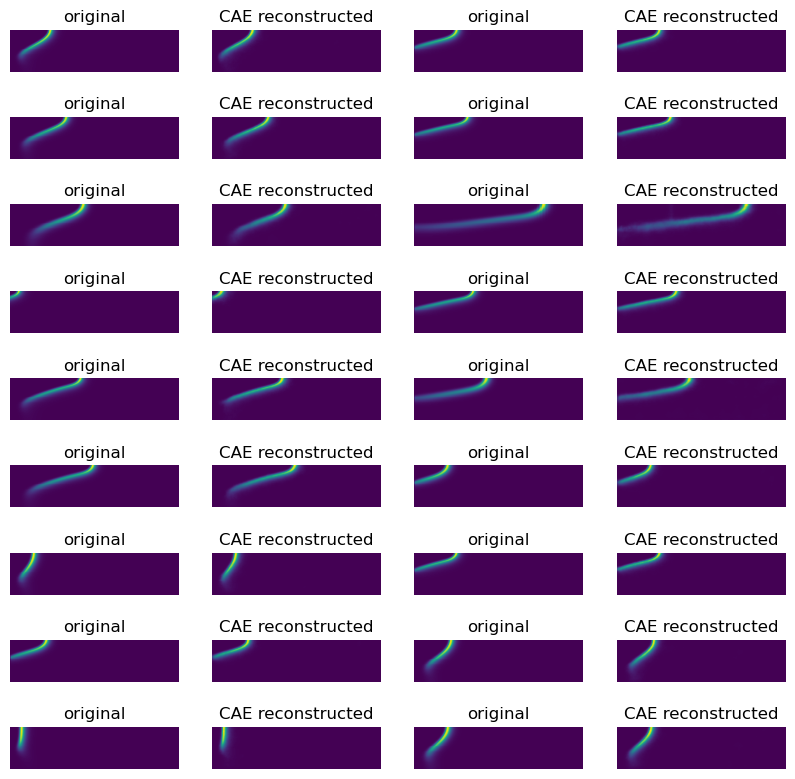

In [16]:
encoded_test_cae = CAE.encoder(test_data).numpy()
decoded_test_cae = CAE.decoder(encoded_test_cae).numpy()

# loops = 9
# images_per_loop = 4

fig = plt.figure(figsize=(10, 10))
columns = 4
rows = 9
for i in range(1, columns * rows + 1, 2):
  img = test_data[i - 1] 
  ax = fig.add_subplot(rows, columns, i)  
  plt.imshow(img)
  plt.title("original")
  plt.axis('off')  

  decoded_img = decoded_test_cae[i - 1]  
  ax = fig.add_subplot(rows, columns, i + 1) 
  plt.imshow(decoded_img)
  plt.title("CAE reconstructed")
  plt.axis('off')  

plt.show()

### VAE

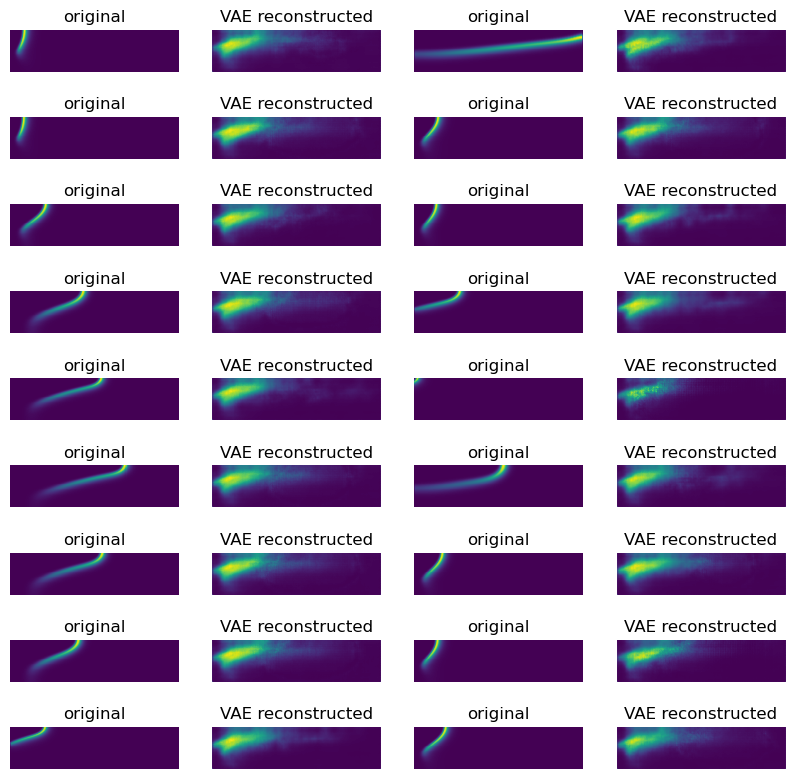

In [17]:
# latent = autoencoder.encoder(test_data).numpy()
encoded_test_vae = VAE.encoder(test_data).numpy()
mean_vae,log_var = tf.split(encoded_test_vae, num_or_size_splits=2, axis=1)
decoded_test_vae = VAE.decoder(VAE.sample(mean_vae,log_var)).numpy()

# loops = 9
# images_per_loop = 4
fig = plt.figure(figsize=(10, 10))
columns = 4
rows = 9
for i in range(1, columns * rows + 1, 2):
  img = test_data[i - 1] 
  ax = fig.add_subplot(rows, columns, i)  
  plt.imshow(img)
  plt.title("original")
  plt.axis('off')  

  decoded_img = decoded_test_vae[i - 1]  
  ax = fig.add_subplot(rows, columns, i + 1) 
  plt.imshow(decoded_img)
  plt.title("VAE reconstructed")
  plt.axis('off')  

plt.show()
# fig, axs = plt.subplots(loops * 2, images_per_loop, figsize=(images_per_loop * 2, loops * 2))

# for loop in range(loops):
#     for i in range(images_per_loop):
#         index = loop * images_per_loop + i
        
#         axs[2 * loop, i].imshow(test_data[index].squeeze())
#         axs[2 * loop, i].axis('off')
#         axs[2 * loop, i].set_title("Original")

#         axs[2 * loop + 1, i].imshow(decoded_test_vae[index].squeeze())
#         axs[2 * loop + 1, i].axis('off')
#         axs[2 * loop + 1, i].set_title("VAE Reconstructed")

# plt.tight_layout()
# plt.show()



# Fully Connected Neural Network

In [17]:
param_dim = conditions.shape[1]

mapping = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape = (param_dim,)), 
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'), 
    tf.keras.layers.Dense(128, activation='relu'),  
    tf.keras.layers.Dense(256, activation='relu'),  
    tf.keras.layers.Dense(512, activation='relu'), 
    tf.keras.layers.Dense(1024, activation='relu'),    
    tf.keras.layers.Dense(latent_dim, activation='linear')
])

mapping.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5), loss='mse')


encoded_train_cae = CAE.encoder(train_data).numpy()


encoded_train_mapping = encoded_train_cae
encoded_test_mapping = encoded_test_cae

hist_mapping = mapping.fit(label_train, encoded_train_mapping, epochs=1000, batch_size=8,validation_data=(label_test,encoded_test_mapping))


Epoch 1/1000
25/25 [==============================] - 1s 12ms/step - loss: 5.6335 - val_loss: 6.3455
Epoch 2/1000
25/25 [==============================] - 0s 5ms/step - loss: 5.4543 - val_loss: 6.1067
Epoch 3/1000
25/25 [==============================] - 0s 7ms/step - loss: 5.2085 - val_loss: 5.7254
Epoch 4/1000
25/25 [==============================] - 0s 5ms/step - loss: 4.9185 - val_loss: 5.3521
Epoch 5/1000
25/25 [==============================] - 0s 6ms/step - loss: 4.7649 - val_loss: 5.2056
Epoch 6/1000
25/25 [==============================] - 0s 6ms/step - loss: 4.7444 - val_loss: 5.1722
Epoch 7/1000
25/25 [==============================] - 0s 7ms/step - loss: 4.7006 - val_loss: 5.0949
Epoch 8/1000
25/25 [==============================] - 0s 6ms/step - loss: 4.6721 - val_loss: 5.0640
Epoch 9/1000
25/25 [==============================] - 0s 6ms/step - loss: 4.6226 - val_loss: 5.0255
Epoch 10/1000
25/25 [==============================] - 0s 6ms/step - loss: 4.5797 - val_loss: 4.953

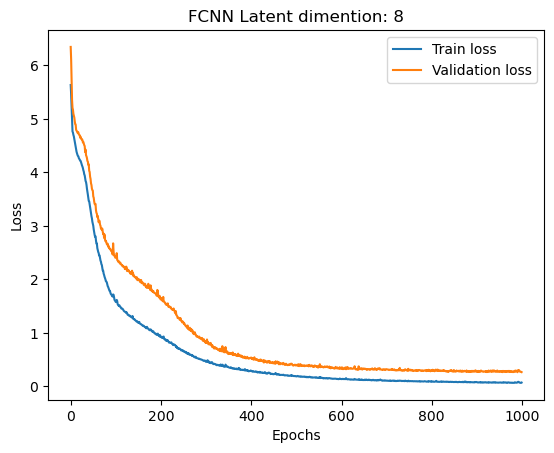

In [19]:
loss_map = hist_mapping.history['loss']
val_loss_map = hist_mapping.history['val_loss']

# plt.semilogy(loss_map, label ='Train loss')
# plt.semilogy(val_loss_map, label = 'Validation loss')
plt.plot(loss_map, label ='Train loss')
plt.plot(val_loss_map, label = 'Validation loss')
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.title(f'FCNN Latent dimention: {latent_dim}')
plt.legend()
plt.show()

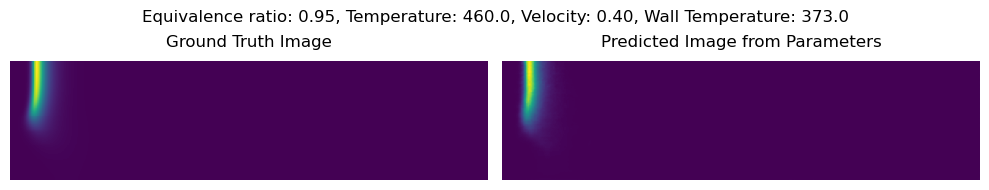

In [24]:
idx = 230
# 20, 32, 100, 170, 230

new_params = df[idx]
params = np.expand_dims(new_params, axis=0)
latent_data = mapping(params)
pred_img = (CAE.decoder(latent_data)).numpy()

#plot the predicted image vs the ground truth
fig = plt.figure(figsize=(10, 2))
img = Qdot[idx]
fig.suptitle(f'Equivalence ratio: {condition[idx][0] * 0.001:.2f}, '
                       f'Temperature: {condition[idx][1]}, '
                       f'Velocity: {condition[idx][2] * 0.01:.2f}, '
                       f'Wall Temperature: {condition[idx][3]}')
ax = fig.add_subplot(1, 2, 1)
plt.imshow(np.squeeze(img))
plt.axis('off')
plt.title("Ground Truth Image", pad=10)

ax = fig.add_subplot(1, 2, 2)
plt.imshow(np.squeeze(pred_img))
plt.title("Predicted Image from Parameters", pad=10)
plt.axis('off')
plt.tight_layout()
plt.show()